# Computer Vision - CIFAR-10 Image Classification

## Project Objective

The main objective of this project is to create a machine learning model that can accurately classify unseen images from the CIFAR-10 dataset into their respective classes. To achieve this, a custom Convolutional Neural Network (CNN) is developed and its performance is benchmarked against pre-trained Keras models to validate its effectiveness.

## Dataset Overview

The CIFAR-10 dataset contains 60,000 32×32 colored images across 10 classes (6,000 images per class):
- **Training set:** 50,000 images
- **Test set:** 10,000 images

**Source:** [CIFAR-10 Dataset Documentation](https://www.cs.toronto.edu/~kriz/cifar.html)

## Project Components

### 1. Data Exploration & Preprocessing
- Class distribution analysis and sample visualization
- Image preprocessing pipeline for model input

### 2. Custom CNN Architecture
- Novel architecture with carefully chosen layers, activation functions, and regularization
- Hyperparameter tuning: learning rate, filter sizes, dropout rates, and layer configurations
- Architectural decisions backed by exploratory analysis

### 3. Model Evaluation & Comparison
- Performance metrics and accuracy analysis
- Benchmark comparison with pre-trained Keras models
- Visualization of results with tables and graphs

### 4. Critical Analysis
- Reflection on model performance
- Discussion of strengths, limitations, and potential improvements

## Technologies Used
- TensorFlow/Keras
- Python
- CIFAR-10 Dataset

### Import the necessary libraries

In [ ]:
!pip install -U scikit-learn==1.3.2 scikeras==0.11.0 --quiet

In [18]:
import tensorflow as tf

# Display the version
print(tf.__version__)

# other imports
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Activation, Conv2D, Dense, Flatten, Dropout
from tensorflow.keras.layers import GlobalMaxPooling2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2.18.0


### Import the Cfar10 data

In [41]:
##Import the cf10 data
from keras.datasets import cifar10

cf = cifar10.load_data() # the CIFAR-10 dataset consists of 32 by 32


# Initial loading and investigation of the data


In [42]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


The first batch of data is the training data which contains 50k instances of images. Each one of these images are colored images, having the dimensions of 32 length by 32 width by 3 channels or height. The train data output is a 2D vector  with 50k rows , each of them with one value which is the one output. This vector represents what class each image in the training data set belongs to. Similarly, the test data is the unseen data and it has 10,000 32 by 32 by 3 images which correspond to the classes in the the 10k y_test vector out put.

# Investigating pixels and shapes
Sample of text data instance and response class insance

3


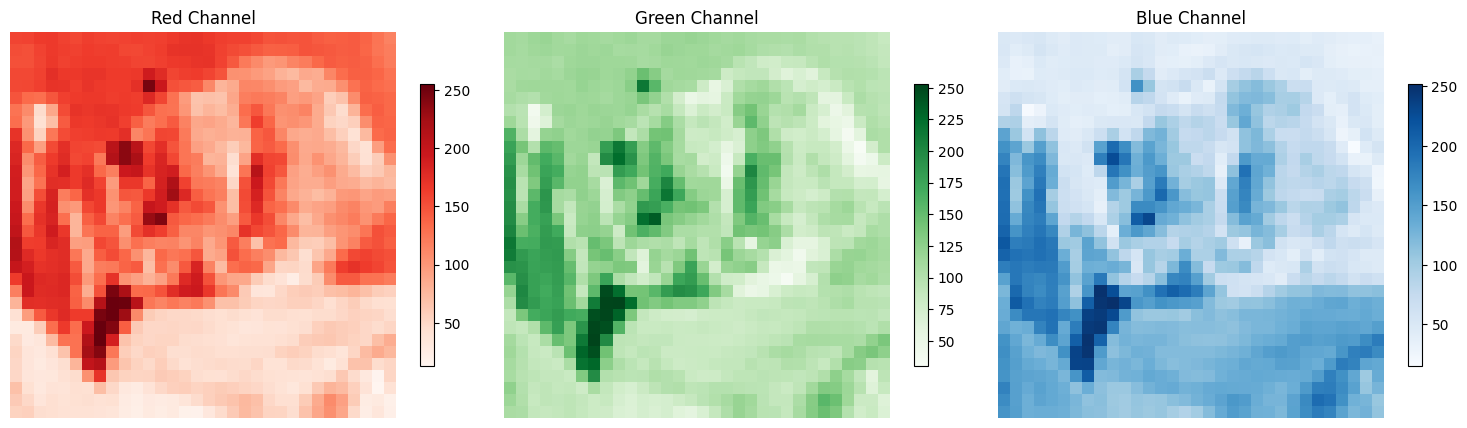

In [ ]:
##show one picture with it's 3 different RGB channels
%matplotlib inline
# Get the first image and label
image = x_test[0]
print(y_test[0][0])  # y_test is shaped (10000, 1)



red_channel = image[:, :, 0]
green_channel = image[:, :, 1]
blue_channel = image[:, :, 2]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))


im0 = axes[0].imshow(red_channel, cmap='Reds')
axes[0].set_title("Red Channel")
axes[0].axis('off')
fig.colorbar(im0, ax=axes[0], shrink=0.6)

#Channels
im1 = axes[1].imshow(green_channel, cmap='Greens')
axes[1].set_title("Green Channel")
axes[1].axis('off')
fig.colorbar(im1, ax=axes[1], shrink=0.6)


im2 = axes[2].imshow(blue_channel, cmap='Blues')
axes[2].set_title("Blue Channel")
axes[2].axis('off')
fig.colorbar(im2, ax=axes[2], shrink=0.6)


plt.tight_layout()
plt.show()




# Normalizing/scaling the data.

The x_train and y_train are colored images with pixels ranging from 0 to 255 as show above. In order to starndadize all pixels inorder to make it easier for the network to train or learn, we need to first scale the data. CNN also works faster when the numbers are standardized. I will use one of the most common methods, which is dividing my 255 to force all the values to range from 0 to 1

In [43]:
# # Reduce pixel values
x_train, x_test = x_train / 255.0, x_test / 255.0

I will leave the respose variable as it is as intergers for now, I am planning to use SparseCategoricalCrossentropy loss for now so the response variable will stay as is.

# **Model Creation**
In this next step, I will start creating the model using tensorflow laters. A Convolution neural network is a kind of neural network where convolution layers are created. The following image illustrates this. In this project, I will create 6 different models and asses their performance as I go 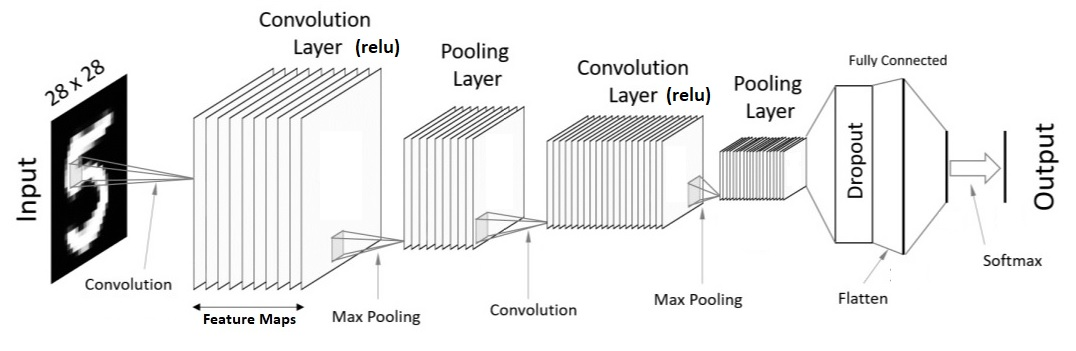

Since this problem is a one input one output kind of a problem, and each training instance is processed individually through out the model, I will use the sequential model. will start by using a sequential model, which is basical a stack of layers.

**THE CNN ARCHITECTURE**

The procedure in convolution neural network is to find useful things, then pool these useful things together, then find more useful things and repeat. These actions are acompished through as set of layers that accomplish a set of actions. For example let us say we want to detect a face, 5 by 5 pixels, we can reconstruct the face by combining black dots in the pixles into lines and angles and edges and angles and curves. The first layer in the convolution network would be to filter across the original image and detect these objects and result in a feature map containing these characteristics. Next wee combine those lines and curves into shapes. eyes ears nose and mouth. So four objects in the next layer, and finally one last layer to combine the ears, nose , eyes and mouth into a face. That final layer being the detector. So the original image of 5 by 5 pixels = a total of 25 pixels going through the network , get reduces to maybe 10 objects, then reduced to 5 objects of eyes, nose, mouth and ears, then reduced to one object which is the face. This is a simpler over view, colored images have to go through the process three times i.e three channels of RBG.  Taking from this example with two layers, the general architecture with two layers would look like this; convolution layer -> max pooling -> dropout -> Convolution layer -> max pooling -> dropout -> then fully connected.
I will start with is kind of architecture and move from there.
Next I will add layers one by one, starting with the

For us to create feature maps from the input later, I need a convolution action. The first argument that we are considering is the number if filters. Filters are small matrices that slide over input matrix, detecting varius shapes and sizes and textures, and the number provided determines how deep the feture map will be.   The kenel size determine the side of the filter. Since the early stages of the Conv net, basic features and shapes are detected, I wall start with small number of layers then increase as I go deep. I will also be chosing 3 by 3 kenel size which is common. and use relu activation for now to enable out puts between 0 and z.

Model one:


1.   Convolution layer with  pooling (2 layers)
2.   3 by 3 filter size (common choice)
3.   Activation functions (relu for con2D layer and softmax for the dense layer)

I started with 32 filters in the first convolutional layer because it's a common starting point for small image datasets. Then I increased the filters to 64 to give the network more capacity to learn complex combinations of the earlier features

I will set the random state to 42 ensure reproducability of the results

In [11]:
Random_STATE = 42

In [22]:
model = Sequential()
model.add (Conv2D(32, ## Number of filters
                  (3,3),  ## kenel size
                  activation = "relu",
                  padding='same',
           input_shape=(32, 32, 3)))
model.add (MaxPooling2D( pool_size = (2, 2)) ) # Reduce resolution while keeping the most important features. I will be using this to half the feature maps. Since we are interested in the shape of a feature as opposed to its location, we use this which progressfuly reduces spacial dimentinals allowing the network to learn


##Next layer with more filters so as to learn more complex fetures

model.add (Conv2D(64, ## Number of filters. Next this layer detects the more complex features and patterns like shapes, textures, combination of lines.
                  (3,3),  ## kenel size
                  activation = "relu") )
model.add (MaxPooling2D( pool_size = (2, 2)) ) ## Reduce resolution while keeping the most important shapes

## Next I will do a Max pooling layer
model.add (Flatten())  # this converts our 3D feature maps to 1D feature vectors

model.add (Dense(128, activation='relu'))  ## Then add a dense layer , with units as the dimentionality of the output space

model.add (Dropout(0.5)) ## Drop out helps prevent overfitting by randomly dropping nodes



#and the final dense layer for 10 output classes

model.add (Dense(10, activation='softmax'))  # Output layer for 10 classes



In [13]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 422,218 (1.61 MB)

 Trainable params: 422,218 (1.61 MB)

 Non-trainable params: 0 (0.00 B)

Now that the model is ready, we can compile it

In [23]:
## Here I am using the default adam optimizer learning rate of 0.001. The sparse_categorical_crossentropy is th right loss function since we have more than two categorical labels
model.compile (optimizer = 'adam',
               loss='sparse_categorical_crossentropy',
               metrics = ['accuracy'])

Once that is done I am ready to train my model now
I will start by training my model in batches of size 32. II know this is the default, but I would like to experiment with it first. Additionally, I will be training the entire dataset, 10 times for starters so epoch will be 10.


In [24]:
history = model.fit(x_train, y_train,batch_size=32,epochs=10,validation_split=0.10)
history

Epoch 1/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.3156 - loss: 1.8513 - val_accuracy: 0.5592 - val_loss: 1.2527
Epoch 2/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5133 - loss: 1.3649 - val_accuracy: 0.6246 - val_loss: 1.0816
Epoch 3/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5681 - loss: 1.2039 - val_accuracy: 0.6290 - val_loss: 1.0670
Epoch 4/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5989 - loss: 1.1224 - val_accuracy: 0.6502 - val_loss: 0.9953
Epoch 5/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6275 - loss: 1.0594 - val_accuracy: 0.6798 - val_loss: 0.9158
Epoch 6/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6524 - loss: 0.9839 - val_accuracy: 0.6760 - val_loss: 0.9189
Epoch 7/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.6660 - loss: 0.9409 - val_accuracy: 0.6942 - val_loss: 0.8908
Epoch 8/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6807 - loss: 0.9054 -

# **Interprating the results**


The loss or cost of my model decreased gradually epoch after epoch, with the difference between the model's predicted values and the actual values decreasing as the model learned, epoch after epoch. This means that the model was improving as the training progressed. Additionally, the accuracy of the model increased gradually. This means that when the model was predicting a cat for instance, and had the task of predicting it as either a cat, a dog , or a mouse,  my model peredicted it as a cat with only around 70% confidence. Because it was unsure of it is a cat, the loss function penalized the model. The model was also able to predict unseen validation data correctly 71% of the time. The model can predict on unseen data or prediction data, about the same rate as it can on the test data. But it is not sure , so the penelization i.e the loss function is as big. However, for starting simple architecture, this was fine

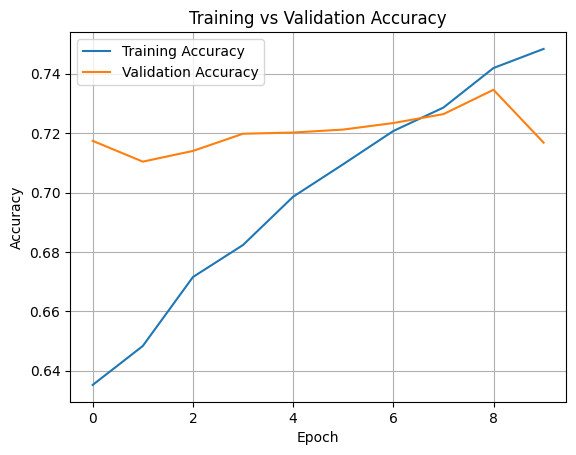

In [12]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

Model evalution
The model test accuracy is 70%. It follows that it predicted unseen data at 70%

In [20]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.7042 - loss: 0.8924
Test Accuracy: 0.7046
Test Loss: 0.8928


The charts below will further show metrics that can rate the model

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step


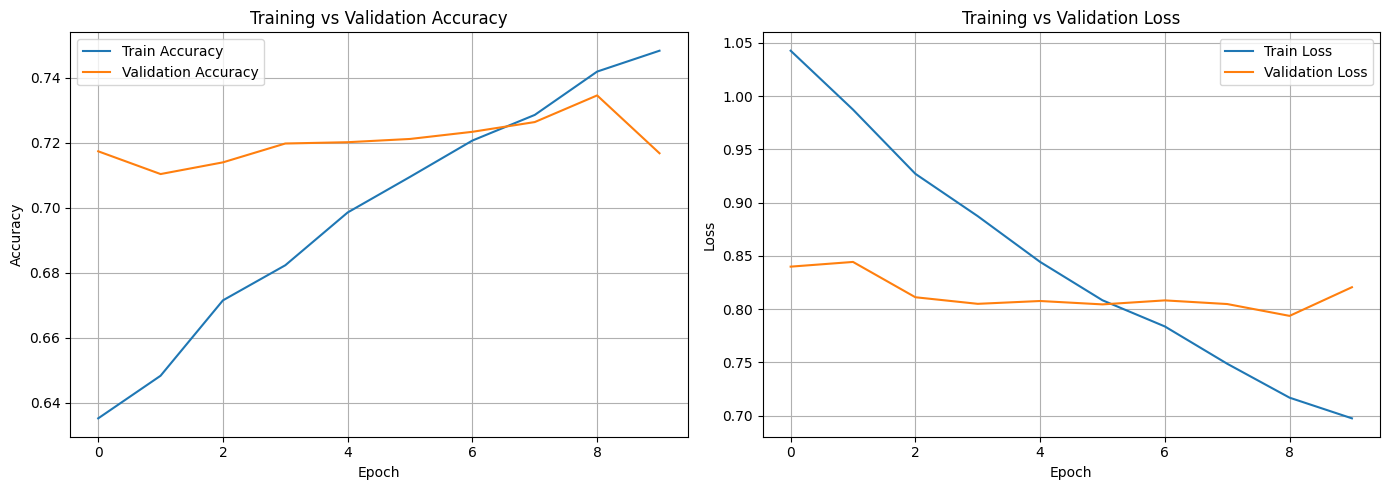

📊 Classification Report Table:



,precision,recall,f1-score,support
0,0.7207,0.7380,0.7292,1000.0000
1,0.8138,0.8350,0.8243,1000.0000
2,0.5186,0.6830,0.5896,1000.0000
3,0.5558,0.4630,0.5052,1000.0000
4,0.6649,0.6270,0.6454,1000.0000
5,0.6108,0.5980,0.6043,1000.0000
6,0.7390,0.7900,0.7637,1000.0000
7,0.8072,0.7410,0.7727,1000.0000
8,0.8015,0.8400,0.8203,1000.0000
9,0.8671,0.7310,0.7933,1000.0000


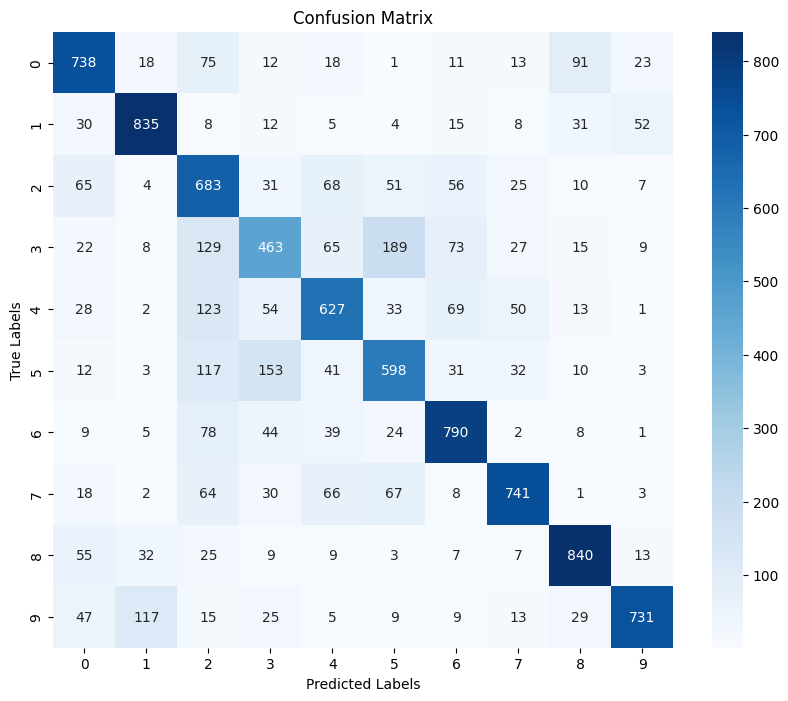

In [19]:

y_pred_probs = model.predict(x_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true = y_test.flatten()

#Classification Table ---
report_dict = classification_report(y_true, y_pred_classes, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

#Accuracy & Loss Plots
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

#Accuracy plot
axs[0].plot(history.history['accuracy'], label='Train Accuracy')
axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axs[0].set_title("Training vs Validation Accuracy")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Accuracy")
axs[0].legend()
axs[0].grid(True)

#Loss plot
axs[1].plot(history.history['loss'], label='Train Loss')
axs[1].plot(history.history['val_loss'], label='Validation Loss')
axs[1].set_title("Training vs Validation Loss")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Loss")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

# Classification Report Table
print("Classification Report Table:\n")
display(report_df.round(4))

#Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(10), yticklabels=range(10))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

**Model Evaluation**

The model accuratly predicted unseen data at 70%
From the table, we see that classes like 1, 8, and 9 performed very well, with F1-scores above 0.82, showing that the model consistently predicted them correctly with high precision and recall.

On the other hand, class 3 had the lowest F1-score (~0.50), showing that the model struggled significantly with this class. If for example this class represented trucks, the low recall shows that out of all the actual truck images, my model only identified about half correctly, and others were misclassified, and out of all the trucks predicted, only a handfull of them were correct. This drove the f1 score down, resulting in overall poor performance in this class.


The confusion matrix confirms this further, with most images that belong to class 3 being confused for class 5. Additionally, most of the images that belonged to class 5, were misinterpretated to belong to clas 3. This means that these two classes have a lot of simmilarities

On further inspection from the documentation of this dataset, the classes were found to be that of cat and dog. cat and dogs have alot of similarities and hence can be mistaken.

In [22]:


cifar10_labels = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

print("Class 3 is:", cifar10_labels[3])
print("Class 5 is:", cifar10_labels[5])

Class 3 is: cat
Class 5 is: dog


Because of this, I will add another layer so that the model can learn deeper patterns. I will also add batch normalization after every conv layer which will help with stability and faster training.

**Results **
When I experimented with an extra convolution layer, and tried 128 filters and 64 filters, both models were performing well on the train data but performing horribly of the validation data. The models were memorizing the training data. Because of this , this approach was discurded.

**Tuning Method 1: Third layer with 128 filters**

The following results will show that adding more layers increased the complexity of the model, took too long to learn, and the the results were worser than the orginal model, so the methods were discarded.

In [23]:
model1 = Sequential()
model1.add (Conv2D(32, ## Number of filters
                  (3,3),  ## kenel size
                  activation = "relu",
                  padding='same',
           input_shape=(32, 32, 3)))
model1.add(BatchNormalization())
model1.add (MaxPooling2D( pool_size = (2, 2)) ) # Reduce resolution while keeping the most important features. I will be using this to half the feature maps. Since we are interested in the shape of a feature as opposed to its location, we use this which progressfuly reduces spacial dimentinals allowing the network to learn


##Next layer with more filters so as to learn more complex fetures

model1.add (Conv2D(64, ## Number of filters. Next this layer detects the more complex features and patterns like shapes, textures, combination of lines.
                  (3,3),  ## kenel size
                  activation = "relu") )
model1.add(BatchNormalization())
model1.add (MaxPooling2D( pool_size = (2, 2)) ) ## Reduce resolution while keeping the most important shapes


model1.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2,2)))

model1.add (Flatten())  # this converts our 3D feature maps to 1D feature vectors

model1.add (Dense(128, activation='relu'))  ## Then add a dense layer , with units as the dimentionality of the output space

model1.add (Dropout(0.5)) ## Drop out helps prevent overfitting by randomly dropping nodes



#and the final dense layer for 10 output classes

model1.add (Dense(10, activation='softmax'))  # Output layer for 10 classes

model1.compile (optimizer = 'adam',
               loss='sparse_categorical_crossentropy',
               metrics = ['accuracy'])

history_1 = model1.fit(x_train, y_train,batch_size=32,epochs=10,validation_split=0.10)
history_1

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 158s 109ms/step - accuracy: 0.3344 - loss: 1.8902 - val_accuracy: 0.5584 - val_loss: 1.2714
Epoch 2/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 201s 108ms/step - accuracy: 0.5409 - loss: 1.2952 - val_accuracy: 0.5536 - val_loss: 1.2600
Epoch 3/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 204s 110ms/step - accuracy: 0.6184 - loss: 1.0753 - val_accuracy: 0.6400 - val_loss: 1.0506
Epoch 4/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 203s 111ms/step - accuracy: 0.6781 - loss: 0.9270 - val_accuracy: 0.6174 - val_loss: 1.1243
Epoch 5/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 206s 114ms/step - accuracy: 0.7142 - loss: 0.8244 - val_accuracy: 0.7052 - val_loss: 0.8679
Epoch 6/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 198s 111ms/step - accuracy: 0.7346 - loss: 0.7486 - val_accuracy: 0.7368 - val_loss: 0.7830
Epoch 7/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 199s 109ms/step - accuracy: 0.7661 - loss: 0.6755 - val_accuracy: 0.7360 - val_loss: 0.7775
Epoch 8/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 210s 115ms/step - ac

Massive overfitting when I added another layer. The model crammed the results

**Tuning Method 2: Third Layer with 64 filters**

In [25]:
model2= Sequential()
model2.add (Conv2D(32, ## Number of filters
                  (3,3),  ## kenel size
                  activation = "relu",
                  padding='same',
           input_shape=(32, 32, 3)))
model2.add(BatchNormalization())
model2.add (MaxPooling2D( pool_size = (2, 2)) ) # Reduce resolution while keeping the most important features. I will be using this to half the feature maps. Since we are interested in the shape of a feature as opposed to its location, we use this which progressfuly reduces spacial dimentinals allowing the network to learn


##Next layer with more filters so as to learn more complex fetures

model2.add (Conv2D(64, ## Number of filters. Next this layer detects the more complex features and patterns like shapes, textures, combination of lines.
                  (3,3),  ## kenel size
                  activation = "relu") )
model2.add(BatchNormalization())
model2.add(MaxPooling2D( pool_size = (2, 2)) ) ## Reduce resolution while keeping the most important shapes


model2.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2,2)))

model2.add (Flatten())  # this converts our 3D feature maps to 1D feature vectors

model2.add (Dense(128, activation='relu'))  ## Then add a dense layer , with units as the dimentionality of the output space

model2.add(Dropout(0.5)) ## Drop out helps prevent overfitting by randomly dropping nodes



#and the final dense layer for 10 output classes

model2.add (Dense(10, activation='softmax'))  # Output layer for 10 classes

model2.compile (optimizer = 'adam',
               loss='sparse_categorical_crossentropy',
               metrics = ['accuracy'])

history_2= model2.fit(x_train, y_train,batch_size=32,epochs=10,validation_split=0.10)
history_2

Epoch 1/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 145s 100ms/step - accuracy: 0.3454 - loss: 1.8824 - val_accuracy: 0.4642 - val_loss: 1.6336
Epoch 2/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 143s 100ms/step - accuracy: 0.5523 - loss: 1.2635 - val_accuracy: 0.5706 - val_loss: 1.3075
Epoch 3/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 144s 102ms/step - accuracy: 0.6258 - loss: 1.0663 - val_accuracy: 0.6004 - val_loss: 1.1327
Epoch 4/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 140s 99ms/step - accuracy: 0.6752 - loss: 0.9268 - val_accuracy: 0.6626 - val_loss: 0.9607
Epoch 5/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 143s 100ms/step - accuracy: 0.7048 - loss: 0.8496 - val_accuracy: 0.6926 - val_loss: 0.8774
Epoch 6/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 142s 100ms/step - accuracy: 0.7291 - loss: 0.7811 - val_accuracy: 0.5736 - val_loss: 1.3757
Epoch 7/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 136s 97ms/step - accuracy: 0.7447 - loss: 0.7250 - val_accuracy: 0.7332 - val_loss: 0.7969
Epoch 8/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 142s 97ms/step - accur

Overfitting

**Tuning Method 3: Third Layer with 64 filters and without max pooling**
This model give me close to the best results without sacrifising overfitting. I will check the metrics again to see the models performance

The model still massively underpredicts dogs and cats, and so I will discard it.

In [26]:
model3= Sequential()
model3.add (Conv2D(32, ## Number of filters
                  (3,3),  ## kenel size
                  activation = "relu",
                  padding='same',
           input_shape=(32, 32, 3)))
model3.add(BatchNormalization())
model3.add (MaxPooling2D( pool_size = (2, 2)) ) # Reduce resolution while keeping the most important features. I will be using this to half the feature maps. Since we are interested in the shape of a feature as opposed to its location, we use this which progressfuly reduces spacial dimentinals allowing the network to learn


##Next layer with more filters so as to learn more complex fetures

model3.add (Conv2D(64, ## Number of filters. Next this layer detects the more complex features and patterns like shapes, textures, combination of lines.
                  (3,3),  ## kenel size
                  activation = "relu") )
model3.add(BatchNormalization())
model3.add(MaxPooling2D( pool_size = (2, 2)) ) ## Reduce resolution while keeping the most important shapes


model3.add(Conv2D(64, (3,3), activation='relu', padding='same'))



model3.add (Flatten())  # this converts our 3D feature maps to 1D feature vectors

model3.add (Dense(128, activation='relu'))  ## Then add a dense layer , with units as the dimentionality of the output space

model3.add(Dropout(0.5)) ## Drop out helps prevent overfitting by randomly dropping nodes



#and the final dense layer for 10 output classes

model3.add(Dense(10, activation='softmax'))  # Output layer for 10 classes

model3.compile (optimizer = 'adam',
               loss='sparse_categorical_crossentropy',
               metrics = ['accuracy'])

history_2= model3.fit(x_train, y_train,batch_size=32,epochs=10,validation_split=0.10)
history_2

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 213s 149ms/step - accuracy: 0.3681 - loss: 1.7573 - val_accuracy: 0.5748 - val_loss: 1.2535
Epoch 2/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 156s 111ms/step - accuracy: 0.5646 - loss: 1.2317 - val_accuracy: 0.6162 - val_loss: 1.0606
Epoch 3/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 190s 102ms/step - accuracy: 0.6397 - loss: 1.0249 - val_accuracy: 0.6254 - val_loss: 1.1002
Epoch 4/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 202s 103ms/step - accuracy: 0.6845 - loss: 0.9058 - val_accuracy: 0.6702 - val_loss: 0.9667
Epoch 5/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 202s 103ms/step - accuracy: 0.7225 - loss: 0.8039 - val_accuracy: 0.7188 - val_loss: 0.8094
Epoch 6/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 202s 103ms/step - accuracy: 0.7476 - loss: 0.7247 - val_accuracy: 0.6766 - val_loss: 0.9581
Epoch 7/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 143s 102ms/step - accuracy: 0.7702 - loss: 0.6522 - val_accuracy: 0.7144 - val_loss: 0.8583
Epoch 8/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 197s 99ms/step - acc

In [27]:
test_loss, test_accuracy = model3.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 40ms/step - accuracy: 0.7355 - loss: 0.8363
Test Accuracy: 0.7283
Test Loss: 0.8549


313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step


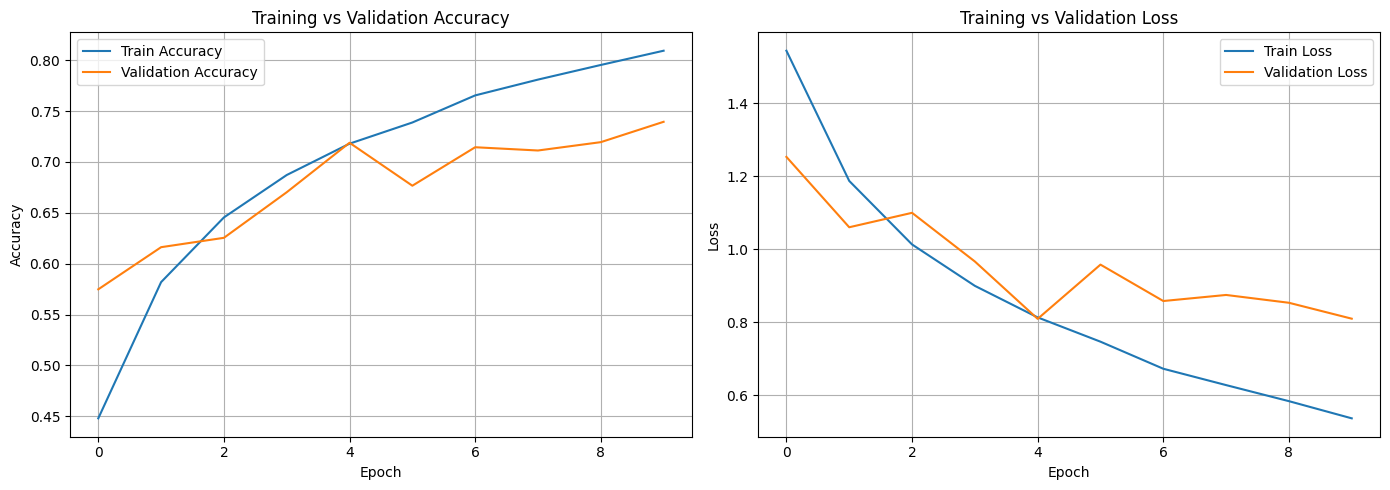

Classification Report Table:



,precision,recall,f1-score,support
0,0.7196,0.7930,0.7545,1000.0000
1,0.8420,0.8740,0.8577,1000.0000
2,0.6484,0.5810,0.6129,1000.0000
3,0.5902,0.4090,0.4832,1000.0000
4,0.6547,0.6770,0.6657,1000.0000
5,0.5841,0.6980,0.6360,1000.0000
6,0.8065,0.8170,0.8117,1000.0000
7,0.7174,0.8250,0.7674,1000.0000
8,0.8907,0.7990,0.8424,1000.0000
9,0.8248,0.8100,0.8174,1000.0000


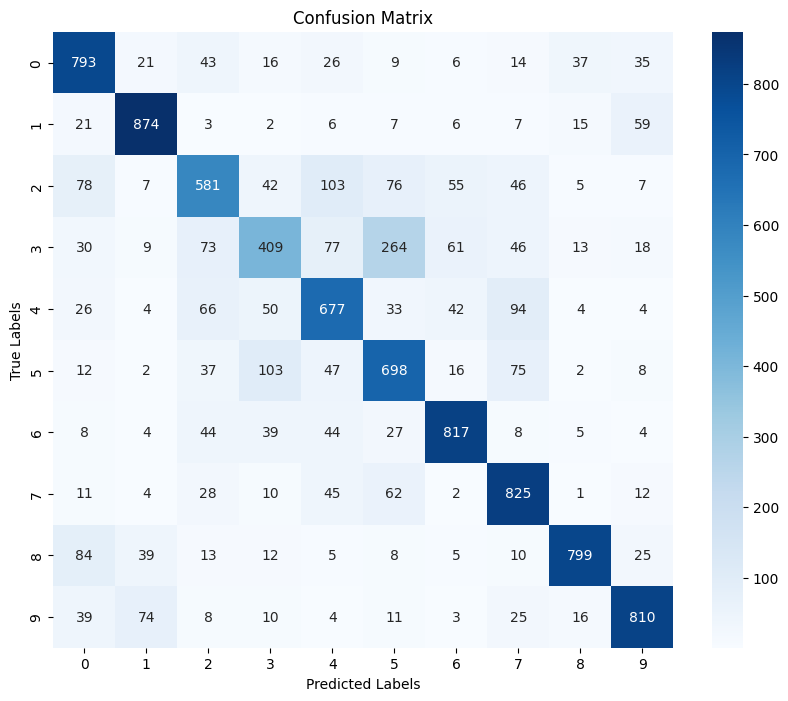

Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


In [29]:
#Predictions

y_pred_probs = model3.predict(x_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true = y_test.flatten()

#Classification Report Table
report_dict = classification_report(y_true, y_pred_classes, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

#Accuracy & Loss Plots
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy plot
axs[0].plot(history_2.history['accuracy'], label='Train Accuracy')
axs[0].plot(history_2.history['val_accuracy'], label='Validation Accuracy')
axs[0].set_title("Training vs Validation Accuracy")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Accuracy")
axs[0].legend()
axs[0].grid(True)

# Loss plot
axs[1].plot(history_2.history['loss'], label='Train Loss')
axs[1].plot(history_2.history['val_loss'], label='Validation Loss')
axs[1].set_title("Training vs Validation Loss")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Loss")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

#Classification Report Table
print("Classification Report Table:\n")
display(report_df.round(4))

#Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(10), yticklabels=range(10))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

The model still massively underpredicts dogs and cats, and so I will discard it.

Because of this I will keep my original model but I will perform data transformations during training so that the model sees cats and dogs in more diverse poses, lighting, angles, or zoomed out versions

In [31]:
datagen = ImageDataGenerator(
    rotation_range=15,         # rotate image randomly
    width_shift_range=0.1,     # shift images to the left or right
    height_shift_range=0.1,    # shift images up or down by 10%
    horizontal_flip=True,      # randomly flip images horizontally
    zoom_range=0.1,            # randomly zoom in
    fill_mode='nearest',       # fill in missing pixels after shift
    validation_split=0.1       # reserve 10% of training data for validation
)

In [32]:
train_gen = datagen.flow(x_train, y_train, batch_size=32, subset='training')
val_gen   = datagen.flow(x_train, y_train, batch_size=32, subset='validation')

Now train the original model with new random versons of each image during each epoch.

results:
This approach did not work and made the model worse at around 65% accuracy compared to the previous results so I will discurd it.

In [33]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10
)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 124s 88ms/step - accuracy: 0.5821 - loss: 1.2132 - val_accuracy: 0.6530 - val_loss: 0.9972
Epoch 2/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 122s 87ms/step - accuracy: 0.6093 - loss: 1.1163 - val_accuracy: 0.6792 - val_loss: 0.9394
Epoch 3/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 125s 89ms/step - accuracy: 0.6181 - loss: 1.0990 - val_accuracy: 0.6846 - val_loss: 0.9131
Epoch 4/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 125s 89ms/step - accuracy: 0.6274 - loss: 1.0603 - val_accuracy: 0.6852 - val_loss: 0.9132
Epoch 5/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 125s 89ms/step - accuracy: 0.6270 - loss: 1.0684 - val_accuracy: 0.6984 - val_loss: 0.8689
Epoch 6/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 126s 89ms/step - accuracy: 0.6284 - loss: 1.0552 - val_accuracy: 0.6976 - val_loss: 0.8906
Epoch 7/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 129s 92ms/step - accuracy: 0.6407 - loss: 1.0225 - val_accuracy: 0.6866 - val_loss: 0.8924
Epoch 8/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 122s 87ms/step - accuracy: 0.6424 - lo

# **Hyperparameter tuning**

I will start with testing drop out rate.Using the whole training set to tune these values were taking to long, over 40 minutes each time. So I decided to subset the data and tune subdets at a time just to get a feel of how it would perform.
PLEASE NOTE THE ERROR IN THIS CODE IS BECAUSE I STOPPED THE RUNNING OF THE CODE, IT WAS TAKING TOO LONG

In [39]:
model_1_2_3 = Sequential()

model_1_2_3.add (Conv2D(32, ## Number of filters
                  (3,3),  ## kenel size
                  activation = "relu", ## I will be using relu function which not only is a popular choice but especially because it introduces non linearlity so that my model can learn more complex features.
                  padding='same',
           input_shape=(32, 32, 3)))

model_1_2_3.add (MaxPooling2D( pool_size = (2, 2)) ) # Reduce resolution while keeping the most important features. I will be using this to half the feature maps. Since we are interested in the shape of a feature as opposed to its location, we use this which progressfuly reduces spacial dimentinals allowing the network to learn


##Next layer with more filters so as to learn more complex fetures


model_1_2_3.add (Conv2D(64, ## Number of filters. Next this layer detects the more complex features and patterns like shapes, textures, combination of lines.
                  (3,3),  ## kenel size
                  activation = "relu",
                      padding='same') )

model_1_2_3.add (MaxPooling2D( pool_size = (2, 2)) ) ## Reduce resolution while keeping the most important shapes




model_1_2_3.add (Flatten())  # this converts our 3D feature maps to 1D feature vectors


model_1_2_3.add (Dense(128, activation='relu'))  ## Then add a dense layer , with units as the dimentionality of the output space


model_1_2_3.add (Dropout(0.6)) ## Drop out helps prevent overfitting by randomly dropping nodes



#and the final dense layer for 10 output classes

model_1_2_3.add (Dense(10, activation='softmax'))  # Output layer for 10 classes

## Here I am using the default adam optimizer learning rate of 0.001

model_1_2_3.compile (optimizer = 'adam',
               loss='sparse_categorical_crossentropy',
               metrics = ['accuracy'])


## with drop out rate, there is 0.5, the model performs at around 58% for both test and validation, although overffiting is reduced significantly, the accuracy is pretty low
## with drop out of 0.4, and batch size 32, the results are the same as the orginal model
## with drop out of 0.4, and batch size 64, there is much less overfitting with A = 63 and V = 58


history_4 = model_1_2_3.fit(x_train, y_train, batch_size = 32, epochs = 10, validation_split = 0.10)
history_4

Epoch 1/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 108s 75ms/step - accuracy: 0.2803 - loss: 1.9253 - val_accuracy: 0.5432 - val_loss: 1.3102
Epoch 2/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 142s 75ms/step - accuracy: 0.4658 - loss: 1.4602 - val_accuracy: 0.6128 - val_loss: 1.1153
Epoch 3/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 142s 75ms/step - accuracy: 0.5291 - loss: 1.3041 - val_accuracy: 0.6318 - val_loss: 1.0465
Epoch 4/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 140s 74ms/step - accuracy: 0.5736 - loss: 1.1962 - val_accuracy: 0.6524 - val_loss: 0.9530
Epoch 5/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 101s 72ms/step - accuracy: 0.5955 - loss: 1.1408 - val_accuracy: 0.6732 - val_loss: 0.9392
Epoch 6/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 160s 85ms/step - accuracy: 0.6234 - loss: 1.0667 - val_accuracy: 0.6818 - val_loss: 0.9381
Epoch 7/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 128s 75ms/step - accuracy: 0.6366 - loss: 1.0202 - val_accuracy: 0.6930 - val_loss: 0.8723
Epoch 8/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 140s 73ms/step - accuracy: 

KeyboardInterrupt: 

In [43]:
#random seed for reproducibility
np.random.seed(42)

#G30% of the data
subset_size = int(0.3 * len(x_train))
indices = np.random.choice(len(x_train), subset_size, replace=False)

#Subset the data
x_sub = x_train[indices]
y_sub = y_train[indices]

#train the model
history_4 = model_1_2_3.fit(
    x_sub, y_sub,
    batch_size=32,
    epochs=10,
    validation_split=0.1
)

Epoch 1/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 32s 76ms/step - accuracy: 0.6835 - loss: 0.9045 - val_accuracy: 0.7700 - val_loss: 0.6602
Epoch 2/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 30s 71ms/step - accuracy: 0.7025 - loss: 0.8259 - val_accuracy: 0.7813 - val_loss: 0.6359
Epoch 3/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 43s 75ms/step - accuracy: 0.7356 - loss: 0.7369 - val_accuracy: 0.7627 - val_loss: 0.6686
Epoch 4/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 33s 79ms/step - accuracy: 0.7359 - loss: 0.7290 - val_accuracy: 0.7693 - val_loss: 0.6479
Epoch 5/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 31s 74ms/step - accuracy: 0.7511 - loss: 0.6778 - val_accuracy: 0.7640 - val_loss: 0.6738
Epoch 6/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 32s 75ms/step - accuracy: 0.7667 - loss: 0.6624 - val_accuracy: 0.7433 - val_loss: 0.7035
Epoch 7/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 40s 72ms/step - accuracy: 0.7820 - loss: 0.6127 - val_accuracy: 0.7607 - val_loss: 0.6934
Epoch 8/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 30s 71ms/step - accuracy: 0.7887 - loss: 0.5846 - 

Increased drop out rate increased the overfitting

**NOTE: **I momentariry disrupted the tuning process so as to fit the State of art model and learn from it, as my tuning efforts were not leading anywhere

**STATE OF ART MODEL**
I will be using the VGG19 model which is a state of art model to compare my results

Fit the VGG19 model

In [36]:
from keras.datasets import cifar10
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import smart_resize

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Resize CIFAR-10 images from 32x32 to 48x48
x_train = tf.image.resize(x_train, [48, 48])
x_test = tf.image.resize(x_test, [48, 48])


# Normalize
x_train = x_train / 255.0
x_test = x_test / 255.0

# One-hot encode labels
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [37]:
from keras.applications import VGG19
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout
from keras.optimizers import Adam

#I will remove the top layer (include_top=False)
vgg = VGG19(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

# Freeze pretrained layers
for layer in vgg.layers:
    layer.trainable = False

# Add custom classifier on top
model_vgg = Sequential([
    vgg,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

model_vgg.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

Train the VGG19 model

In [40]:
history_vgg = model_vgg.fit(x_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

# Final test evaluation
test_loss_vgg, test_acc_vgg = model_vgg.evaluate(x_test, y_test)
print("VGG19 Test Accuracy:", test_acc_vgg)

Epoch 1/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 26s 18ms/step - accuracy: 0.4941 - loss: 1.4487 - val_accuracy: 0.5478 - val_loss: 1.3232
Epoch 2/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 41s 19ms/step - accuracy: 0.5033 - loss: 1.4259 - val_accuracy: 0.5486 - val_loss: 1.3055
Epoch 3/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 44s 21ms/step - accuracy: 0.5103 - loss: 1.4094 - val_accuracy: 0.5584 - val_loss: 1.2828
Epoch 4/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 39s 19ms/step - accuracy: 0.5167 - loss: 1.3890 - val_accuracy: 0.5622 - val_loss: 1.2683
Epoch 5/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 42s 20ms/step - accuracy: 0.5276 - loss: 1.3657 - val_accuracy: 0.5686 - val_loss: 1.2596
Epoch 6/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 42s 21ms/step - accuracy: 0.5317 - loss: 1.3462 - val_accuracy: 0.5710 - val_loss: 1.2417
Epoch 7/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 29s 20ms/step - accuracy: 0.5325 - loss: 1.3359 - val_accuracy: 0.5758 - val_loss: 1.2314
Epoch 8/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 44s 23ms/step - accuracy: 0.5359 -

Validate

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step


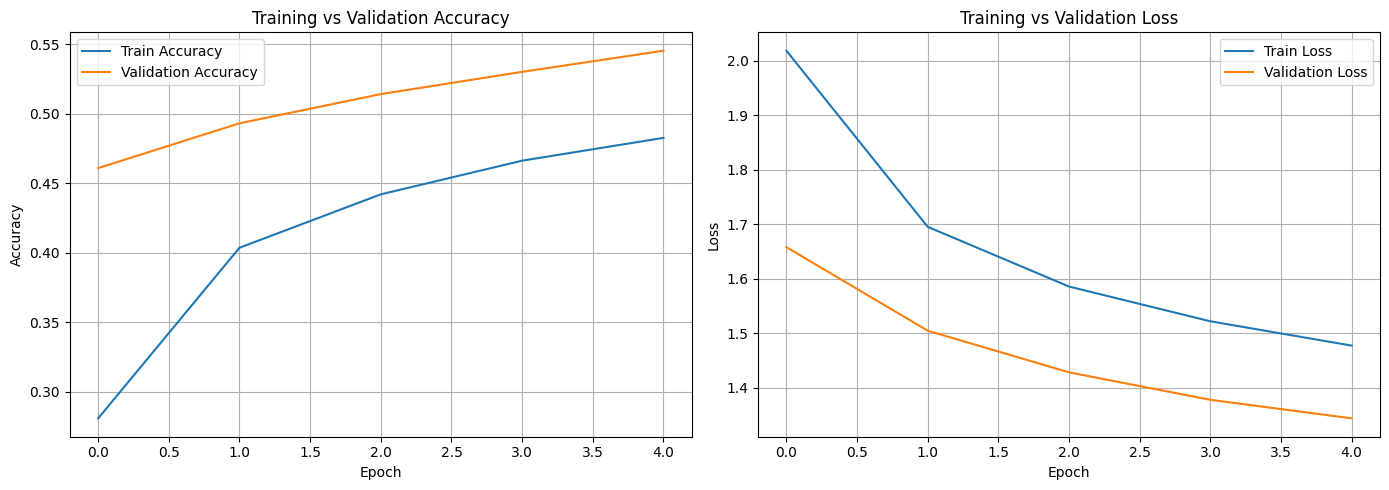

Classification Report Table:



,precision,recall,f1-score,support
0,0.6109,0.5620,0.5854,1000.0000
1,0.5755,0.5680,0.5717,1000.0000
2,0.4573,0.3590,0.4022,1000.0000
3,0.4199,0.3800,0.3990,1000.0000
4,0.5142,0.4720,0.4922,1000.0000
5,0.4908,0.5330,0.5110,1000.0000
6,0.5275,0.6240,0.5717,1000.0000
7,0.5699,0.5910,0.5803,1000.0000
8,0.5955,0.6390,0.6165,1000.0000
9,0.5425,0.6000,0.5698,1000.0000


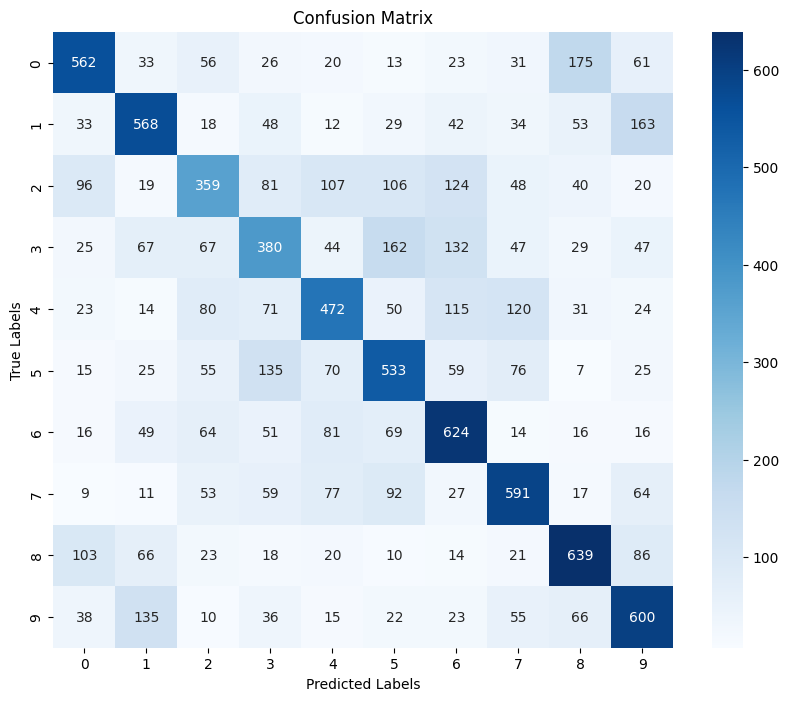

In [39]:


y_pred_probs = model_vgg.predict(x_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# --- Get true labels from one-hot encoding ---
y_true = np.argmax(y_test, axis=1)

# --- Classification Report Table ---
report_dict = classification_report(y_true, y_pred_classes, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

# --- Accuracy & Loss Plots ---
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy plot
axs[0].plot(history_vgg.history['accuracy'], label='Train Accuracy')
axs[0].plot(history_vgg.history['val_accuracy'], label='Validation Accuracy')
axs[0].set_title("Training vs Validation Accuracy")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Accuracy")
axs[0].legend()
axs[0].grid(True)

# Loss plot
axs[1].plot(history_vgg.history['loss'], label='Train Loss')
axs[1].plot(history_vgg.history['val_loss'], label='Validation Loss')
axs[1].set_title("Training vs Validation Loss")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Loss")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

# --- Classification Report Table ---
print("Classification Report Table:\n")
display(report_df.round(4))

# --- Confusion Matrix ---
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(10), yticklabels=range(10))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

Back to Hyperparameter tuning

In [ ]:
# --- Classification Report Table ---
data = {
    'Dropout': [0.3, 0.4, 0.5, 0.6],
    'Accuracy': [93.2, 92.8, 95.4, 91.7, 90.2],
    'Sensitivity': [93.1, 92.1, 95.3, 91.0, 90.5],
    'Specificity': [93.8, 92.9, 95.9, 92.0, 91.2],
    'F1-Score': [93.0, 92.5, 95.2, 91.5, 90.8]
}

df = pd.DataFrame(data)
report_dict = classification_report(y_true, y_pred_classes, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
# --- Classification Report Table ---
print("Classification Report Table:\n")
display(report_df.round(4))

In [35]:
test_loss, test_accuracy = model_1_2_3.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 43ms/step - accuracy: 0.7052 - loss: 0.8627
Test Accuracy: 0.7043
Test Loss: 0.8579


**I FURTHER EXPERIMENTED WITH MORE LAYERS AND DIFFERENT SETTINGS LIKE NUMBER OF BACHES, NUMBER OF EPOCHS, NUMBER OF FILTERS ETC. I DID AN EXAUSTIVE SEARCH AND MY RESULTS STILL LED TO ME DISCARDING THE MODELS AND RETAINING WHAT I HAD AS THE FIRST MODEL.** I will now experiment with the architecture so as to see how I can improove the model

 I would say that I have colored and complex images, some of which the diffrencialer  details more complex than just shapes and textures. Because of this, my next experimentation will be to add more layer to the architexture
 accuracy: 0.7600 - loss: 0.6822 - val_accuracy: 0.7248

In [44]:
model_1 = Sequential()

model_1.add (Conv2D(32, ## Number of filters
                  (3,3),  ## kenel size
                  activation = "relu", ## I will be using relu function which not only is a popular choice but especially because it introduces non linearlity so that my model can learn more complex features.
                  padding='same',
           input_shape=(32, 32, 3)))
model_1.add (MaxPooling2D( pool_size = (2, 2)) ) # Reduce resolution while keeping the most important features. I will be using this to half the feature maps. Since we are interested in the shape of a feature as opposed to its location, we use this which progressfuly reduces spacial dimentinals allowing the network to learn


##Next layer with more filters so as to learn more complex fetures

model_1.add(Conv2D(64, ## Number of filters. Next this layer detects the more complex features and patterns like shapes, textures, combination of lines.
                  (3,3),  ## kenel size
                  activation = "relu") )
model_1.add (MaxPooling2D( pool_size = (2, 2)) ) ## Reduce resolution while keeping the most important shapes

## Next I will do a Max pooling layer

##add third layer
model_1.add (Conv2D(64, ## Number of filters. Next this layer detects the more complex features and patterns like shapes, textures, combination of lines.
                  (3,3),  ## kenel size
                  activation = "relu") )


model_1.add (Flatten())  # this converts our 3D feature maps to 1D feature vectors

model_1.add (Dense(128, activation='relu'))  ## Then add a dense layer , with units as the dimentionality of the output space

model_1.add (Dropout(0.5)) ## Drop out helps prevent overfitting by randomly dropping nodes



#and the final dense layer for 10 output classes
model_1.add (Dense(10, activation='softmax'))  # Output layer for 10 classes

## Here I am using the default adam optimizer learning rate of 0.001
model_1.compile (optimizer = 'adam',
               loss='sparse_categorical_crossentropy',
               metrics = ['accuracy'])

history_1 = model_1.fit(x_train, y_train, batch_size = 32, epochs = 10, validation_split = 0.1)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.3194 - loss: 1.8280 - val_accuracy: 0.5392 - val_loss: 1.2688
Epoch 2/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.5357 - loss: 1.2931 - val_accuracy: 0.6272 - val_loss: 1.0491
Epoch 3/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6101 - loss: 1.1150 - val_accuracy: 0.6716 - val_loss: 0.9373
Epoch 4/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6479 - loss: 1.0084 - val_accuracy: 0.6876 - val_loss: 0.8953
Epoch 5/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.6745 - loss: 0.9286 - val_accuracy: 0.7052 - val_loss: 0.8539
Epoch 6/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.6967 - loss: 0.8552 - val_accuracy: 0.7142 - val_loss: 0.8200
Epoch 7/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.7115 - loss: 0.8121 - val_accuracy: 0.7214 - val_loss: 0.8094
Epoch 8/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.7321 - loss: 0.76

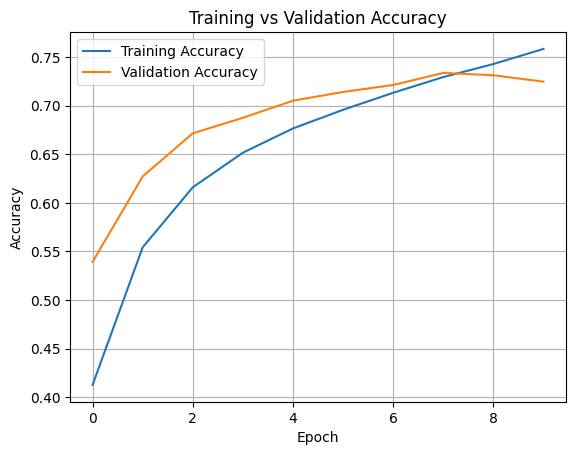

In [45]:
# Plot accuracy
plt.plot(history_1.history['accuracy'], label='Training Accuracy')
plt.plot(history_1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

When I try to add a layer my model improves a little bit. For now I will keep this extra layer the layers of the architecture  as is.

I will try the number of epochs and number of batch size

In [46]:
model_1_2 = Sequential()

model_1_2.add (Conv2D(32, ## Number of filters
                  (3,3),  ## kenel size
                  activation = "relu", ## I will be using relu function which not only is a popular choice but especially because it introduces non linearlity so that my model can learn more complex features.
                  padding='same',
           input_shape=(32, 32, 3)))

model_1_2.add (MaxPooling2D( pool_size = (2, 2)) ) # Reduce resolution while keeping the most important features. I will be using this to half the feature maps. Since we are interested in the shape of a feature as opposed to its location, we use this which progressfuly reduces spacial dimentinals allowing the network to learn


##Next layer with more filters so as to learn more complex fetures


model_1_2.add (Conv2D(64, ## Number of filters. Next this layer detects the more complex features and patterns like shapes, textures, combination of lines.
                  (3,3),  ## kenel size
                  activation = "relu",
                      padding='same') )

model_1_2.add (MaxPooling2D( pool_size = (2, 2)) ) ## Reduce resolution while keeping the most important shapes




model_1_2.add (Flatten())  # this converts our 3D feature maps to 1D feature vectors


model_1_2.add (Dense(128, activation='relu'))  ## Then add a dense layer , with units as the dimentionality of the output space


model_1_2.add (Dropout(0.5)) ## Drop out helps prevent overfitting by randomly dropping nodes



#and the final dense layer for 10 output classes

model_1_2.add (Dense(10, activation='softmax'))  # Output layer for 10 classes

## Here I am using the default adam optimizer learning rate of 0.001

model_1_2.compile (optimizer = 'adam',
               loss='sparse_categorical_crossentropy',
               metrics = ['accuracy'])



## with batch size 32 and epochs 30, A = 83, Val = 60 - massive overfitting, slow training
## with batch size 32 and peochs 20 A = 77 Val = 61 - massive overfitting, slow training
## with epochs size 32 and epochs 10, A = 63 Val = 59 - Less Accuracy but less and managed , no overfitting, less computation time


##test the batch sizes different options
## with batch size 64 and epoch 10, A = 57 Val = 58 - less accuracy and validation, but the overfitting is basically completetly eliminated,

model_1_2.fit(x_train, y_train, batch_size = 32, epochs = 20, validation_split = 0.10)


Epoch 1/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.3293 - loss: 1.8233 - val_accuracy: 0.5470 - val_loss: 1.2756
Epoch 2/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5266 - loss: 1.3195 - val_accuracy: 0.6042 - val_loss: 1.1445
Epoch 3/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5848 - loss: 1.1682 - val_accuracy: 0.6498 - val_loss: 1.0095
Epoch 4/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6153 - loss: 1.0814 - val_accuracy: 0.6626 - val_loss: 0.9578
Epoch 5/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6465 - loss: 0.9901 - val_accuracy: 0.6822 - val_loss: 0.9011
Epoch 6/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6708 - loss: 0.9345 - val_accuracy: 0.6966 - val_loss: 0.8655
Epoch 7/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6830 - loss: 0.8840 - val_accuracy: 0.7040 - val_loss: 0.8588
Epoch 8/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.7021 - loss: 0.835

Model imporved to 77 but ,massive over fitting.

# Plot accuracy
plt.plot(history_1.history['accuracy'], label='Training Accuracy')
plt.plot(history_1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

I will try the same but with a third layer. This resulted in massive overfitting

In [47]:
model_1_21 = Sequential()

model_1_21.add (Conv2D(32, ## Number of filters
                  (3,3),  ## kenel size
                  activation = "relu", ## I will be using relu function which not only is a popular choice but especially because it introduces non linearlity so that my model can learn more complex features.
                  padding='same',
           input_shape=(32, 32, 3)))

model_1_21.add (MaxPooling2D( pool_size = (2, 2)) ) # Reduce resolution while keeping the most important features. I will be using this to half the feature maps. Since we are interested in the shape of a feature as opposed to its location, we use this which progressfuly reduces spacial dimentinals allowing the network to learn


##Next layer with more filters so as to learn more complex fetures

model_1_21.add (Conv2D(64, ## Number of filters. Next this layer detects the more complex features and patterns like shapes, textures, combination of lines.
                  (3,3),  ## kenel size
                  activation = "relu",
                      padding='same') )

model_1_21.add (MaxPooling2D( pool_size = (2, 2)) ) ## Reduce resolution while keeping the most important shapes


model_1_21.add (Conv2D(64, ## Number of filters. Next this layer detects the more complex features and patterns like shapes, textures, combination of lines.
                  (3,3),  ## kenel size
                  activation = "relu",
                      padding='same') )


model_1_21.add (Flatten())  # this converts our 3D feature maps to 1D feature vectors


model_1_21.add (Dense(128, activation='relu'))  ## Then add a dense layer , with units as the dimentionality of the output space


model_1_21.add (Dropout(0.5)) ## Drop out helps prevent overfitting by randomly dropping nodes



#and the final dense layer for 10 output classes

model_1_21.add (Dense(10, activation='softmax'))  # Output layer for 10 classes

## Here I am using the default adam optimizer learning rate of 0.001

model_1_21.compile (optimizer = 'adam',
               loss='sparse_categorical_crossentropy',
               metrics = ['accuracy'])



## with batch size 32 and epochs 30, A = 83, Val = 60 - massive overfitting, slow training
## with batch size 32 and peochs 20 A = 77 Val = 61 - massive overfitting, slow training
## with epochs size 32 and epochs 10, A = 63 Val = 59 - Less Accuracy but less and managed , no overfitting, less computation time


##test the batch sizes different options
## with batch size 64 and epoch 10, A = 57 Val = 58 - less accuracy and validation, but the overfitting is basically completetly eliminated,

history_3 = model_1_21.fit(x_train, y_train, batch_size = 32, epochs = 20, validation_split = 0.10)


Epoch 1/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.3268 - loss: 1.8210 - val_accuracy: 0.5438 - val_loss: 1.2426
Epoch 2/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5529 - loss: 1.2595 - val_accuracy: 0.6126 - val_loss: 1.0853
Epoch 3/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6264 - loss: 1.0629 - val_accuracy: 0.6966 - val_loss: 0.8677
Epoch 4/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6716 - loss: 0.9363 - val_accuracy: 0.7100 - val_loss: 0.8459
Epoch 5/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6985 - loss: 0.8647 - val_accuracy: 0.7112 - val_loss: 0.8285
Epoch 6/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7228 - loss: 0.7823 - val_accuracy: 0.7322 - val_loss: 0.7915
Epoch 7/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7429 - loss: 0.7302 - val_accuracy: 0.7150 - val_loss: 0.8231
Epoch 8/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.7622 - loss: 0.6726 

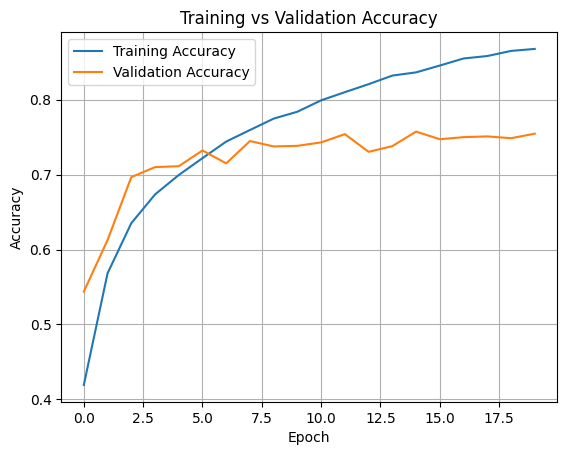

In [48]:
# Plot accuracy
plt.plot(history_3.history['accuracy'], label='Training Accuracy')
plt.plot(history_3.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

**Notes **

 with batch size 32 and epochs 30, A = 83, Val = 60 - massive overfitting, slow training
 with batch size 32 and peochs 20 A = 77 Val = 61 - massive overfitting, slow training
with epochs size 32 and epochs 10, A = 63 Val = 59 - Less Accuracy but less and managed , no overfitting, less computation time


test the batch sizes different options
with batch size 64 and epoch 10, A = 57 Val = 58 - less accuracy and validation, but the overfitting is basically completetly eliminated.

For now I will stick with batch 64, and epoch 10

In [49]:
model_1_212 = Sequential()

model_1_212.add (Conv2D(32, ## Number of filters
                  (3,3),  ## kenel size
                  activation = "relu", ## I will be using relu function which not only is a popular choice but especially because it introduces non linearlity so that my model can learn more complex features.
                  padding='same',
           input_shape=(32, 32, 3)))

model_1_212.add (MaxPooling2D( pool_size = (2, 2)) ) # Reduce resolution while keeping the most important features. I will be using this to half the feature maps. Since we are interested in the shape of a feature as opposed to its location, we use this which progressfuly reduces spacial dimentinals allowing the network to learn


##Next layer with more filters so as to learn more complex fetures
model_1_212.add (Conv2D(64, ## Number of filters. Next this layer detects the more complex features and patterns like shapes, textures, combination of lines.
                  (3,3),  ## kenel size
                  activation = "relu",
                      padding='same') )
model_1_212.add (MaxPooling2D( pool_size = (2, 2)) ) ## Reduce resolution while keeping the most important shapes


model_1_212.add (Conv2D(64, ## Number of filters. Next this layer detects the more complex features and patterns like shapes, textures, combination of lines.
                  (3,3),  ## kenel size
                  activation = "relu") )


model_1_212.add (Flatten())  # this converts our 3D feature maps to 1D feature vectors


model_1_212.add (Dense(128, activation='relu'))  ## Then add a dense layer , with units as the dimentionality of the output space


model_1_212.add (Dropout(0.5)) ## Drop out helps prevent overfitting by randomly dropping nodes



#and the final dense layer for 10 output classes

model_1_212.add (Dense(10, activation='softmax'))  # Output layer for 10 classes

## Here I am using the default adam optimizer learning rate of 0.001

model_1_212.compile (optimizer = 'adam',
               loss='sparse_categorical_crossentropy',
               metrics = ['accuracy'])



## with batch size 32 and epochs 30, A = 83, Val = 60 - massive overfitting, slow training
## with batch size 32 and peochs 20 A = 77 Val = 61 - massive overfitting, slow training
## with epochs size 32 and epochs 10, A = 63 Val = 59 - Less Accuracy but less and managed , no overfitting, less computation time


##test the batch sizes different options
## with batch size 64 and epoch 10, A = 57 Val = 58 - less accuracy and validation, but the overfitting is basically completetly eliminated,

history_4 = model_1_212.fit(x_train, y_train, batch_size = 32, epochs = 10, validation_split = 0.10)

Epoch 1/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.3055 - loss: 1.8752 - val_accuracy: 0.5570 - val_loss: 1.2586
Epoch 2/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5280 - loss: 1.3243 - val_accuracy: 0.6220 - val_loss: 1.0569
Epoch 3/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6000 - loss: 1.1376 - val_accuracy: 0.6604 - val_loss: 0.9472
Epoch 4/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6439 - loss: 1.0115 - val_accuracy: 0.6802 - val_loss: 0.8983
Epoch 5/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6786 - loss: 0.9169 - val_accuracy: 0.6988 - val_loss: 0.8865
Epoch 6/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.7018 - loss: 0.8599 - val_accuracy: 0.7112 - val_loss: 0.8378
Epoch 7/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7177 - loss: 0.8051 - val_accuracy: 0.7220 - val_loss: 0.8124
Epoch 8/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.7376 - loss: 0.749

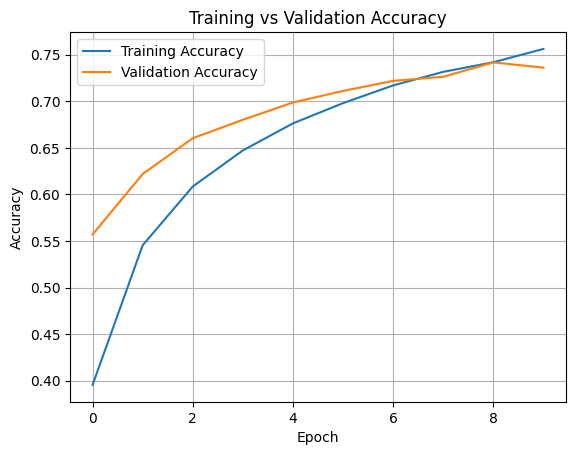

In [50]:
# Plot accuracy
plt.plot(history_4.history['accuracy'], label='Training Accuracy')
plt.plot(history_4.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

**Next I will test the drop out rate**

In [51]:
model_1_2_3 = Sequential()

model_1_2_3.add (Conv2D(32, ## Number of filters
                  (3,3),  ## kenel size
                  activation = "relu", ## I will be using relu function which not only is a popular choice but especially because it introduces non linearlity so that my model can learn more complex features.
                  padding='same',
           input_shape=(32, 32, 3)))

model_1_2_3.add (MaxPooling2D( pool_size = (2, 2)) ) # Reduce resolution while keeping the most important features. I will be using this to half the feature maps. Since we are interested in the shape of a feature as opposed to its location, we use this which progressfuly reduces spacial dimentinals allowing the network to learn


##Next layer with more filters so as to learn more complex fetures


model_1_2_3.add (Conv2D(64, ## Number of filters. Next this layer detects the more complex features and patterns like shapes, textures, combination of lines.
                  (3,3),  ## kenel size
                  activation = "relu",
                      padding='same') )

model_1_2_3.add (MaxPooling2D( pool_size = (2, 2)) ) ## Reduce resolution while keeping the most important shapes




model_1_2_3.add (Flatten())  # this converts our 3D feature maps to 1D feature vectors


model_1_2_3.add (Dense(128, activation='relu'))  ## Then add a dense layer , with units as the dimentionality of the output space


model_1_2_3.add (Dropout(0.4)) ## Drop out helps prevent overfitting by randomly dropping nodes



#and the final dense layer for 10 output classes

model_1_2_3.add (Dense(10, activation='softmax'))  # Output layer for 10 classes

## Here I am using the default adam optimizer learning rate of 0.001

model_1_2_3.compile (optimizer = 'adam',
               loss='sparse_categorical_crossentropy',
               metrics = ['accuracy'])


## with drop out rate, there is 0.5, the model performs at around 58% for both test and validation, although overffiting is reduced significantly, the accuracy is pretty low
## with drop out of 0.4, and batch size 32, there is overfitting, A = 69, Val = 61
## with drop out of 0.4, and batch size 64, there is much less overfitting with A = 63 and V = 58


model_1_2_3.fit(x_train, y_train, batch_size = 32, epochs = 10, validation_split = 0.10)


Epoch 1/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.3354 - loss: 1.8056 - val_accuracy: 0.5230 - val_loss: 1.3515
Epoch 2/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5294 - loss: 1.3127 - val_accuracy: 0.6154 - val_loss: 1.0843
Epoch 3/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5889 - loss: 1.1590 - val_accuracy: 0.6440 - val_loss: 1.0074
Epoch 4/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6187 - loss: 1.0752 - val_accuracy: 0.6598 - val_loss: 0.9855
Epoch 5/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6414 - loss: 1.0067 - val_accuracy: 0.6920 - val_loss: 0.8822
Epoch 6/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6655 - loss: 0.9418 - val_accuracy: 0.6814 - val_loss: 0.9092
Epoch 7/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6747 - loss: 0.9113 - val_accuracy: 0.6980 - val_loss: 0.8591
Epoch 8/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6957 - loss: 0.8549 - val_accuracy: 0.

with drop out rate, there is 0.5, the model performs at around 58% for both test and validation, although overffiting is reduced significantly, the accuracy is pretty low
with drop out of 0.4, and batch size 32, there is overfitting, A = 69, Val = 61
 with drop out of 0.4, and batch size 64, there is much less overfitting with A = 63 and V = 58


Dense nodes
Experiment in the dense layer

In [52]:

model_1_2_3_4= Sequential()


model_1_2_3_4.add (Conv2D(32, ## Number of filters
                  (3,3),  ## kenel size
                  activation = "relu", ## I will be using relu function which not only is a popular choice but especially because it introduces non linearlity so that my model can learn more complex features.
                  padding='same',
           input_shape=(32, 32, 3)))

model_1_2_3_4.add (MaxPooling2D( pool_size = (2, 2)) ) # Reduce resolution while keeping the most important features. I will be using this to half the feature maps. Since we are interested in the shape of a feature as opposed to its location, we use this which progressfuly reduces spacial dimentinals allowing the network to learn


##Next layer with more filters so as to learn more complex fetures


model_1_2_3_4.add (Conv2D(48, ## Number of filters. Next this layer detects the more complex features and patterns like shapes, textures, combination of lines.
                  (3,3),  ## kenel size
                  activation = "relu",
                      padding='same') )


model_1_2_3_4.add (MaxPooling2D( pool_size = (2, 2)) ) ## Reduce resolution while keeping the most important shapes



model_1_2_3_4.add(Conv2D(64, (3, 3), activation='relu'))

model_1_2_3_4.add (Flatten())  # this converts our 3D feature maps to 1D feature vectors



model_1_2_3_4.add (Dense(64, activation='relu'))  ## Then add a dense layer , with units as the dimentionality of the output space



model_1_2_3_4.add (Dropout(0.4)) ## Drop out helps prevent overfitting by randomly dropping nodes



#and the final dense layer for 10 output classes

model_1_2_3_4.add (Dense(10, activation='softmax'))  # Output layer for 10 classes

## Here I am using the default adam optimizer learning rate of 0.001


model_1_2_3_4.compile (optimizer = 'adam',
               loss='sparse_categorical_crossentropy',
               metrics = ['accuracy'])


## Add one conv layer , A = 66, V = 67
## change dense notes to 64



model_1_2_3_4.fit(x_train, y_train, batch_size = 32, epochs = 10, validation_split = 0.10)


Epoch 1/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.3105 - loss: 1.8603 - val_accuracy: 0.5322 - val_loss: 1.3036
Epoch 2/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5245 - loss: 1.3264 - val_accuracy: 0.6300 - val_loss: 1.0469
Epoch 3/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5940 - loss: 1.1468 - val_accuracy: 0.6670 - val_loss: 0.9519
Epoch 4/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6359 - loss: 1.0384 - val_accuracy: 0.6372 - val_loss: 1.0553
Epoch 5/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6635 - loss: 0.9599 - val_accuracy: 0.6958 - val_loss: 0.8761
Epoch 6/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6898 - loss: 0.8961 - val_accuracy: 0.7150 - val_loss: 0.8220
Epoch 7/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.7048 - loss: 0.8382 - val_accuracy: 0.6808 - val_loss: 0.9362
Epoch 8/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7163 - loss: 0.8044

This model us better but it is too slow and the difference between accuracy and validation accuracy is too big at 84% vs 60% meaning the model is memorizing the data.

I will test regularization

In [53]:
model_1_3 = Sequential()

model_1_3.add (Conv2D(32, ## Number of filters
                  (3,3),  ## kenel size
                  activation = "relu", ## I will be using relu function which not only is a popular choice but especially because it introduces non linearlity so that my model can learn more complex features.
                  padding='same',
           input_shape=(32, 32, 3)))

model_1_3.add (MaxPooling2D( pool_size = (2, 2)) ) # Reduce resolution while keeping the most important features. I will be using this to half the feature maps. Since we are interested in the shape of a feature as opposed to its location, we use this which progressfuly reduces spacial dimentinals allowing the network to learn


##Next layer with more filters so as to learn more complex fetures


model_1_3.add (Conv2D(48, ## Number of filters. Next this layer detects the more complex features and patterns like shapes, textures, combination of lines.
                  (3,3),  ## kenel size
                  activation = "relu") )

model_1_3.add (MaxPooling2D( pool_size = (2, 2)) ) ## Reduce resolution while keeping the most important shapes



model_1_3.add (Flatten())  # this converts our 3D feature maps to 1D feature vectors


model_1_3.add (Dense(128, activation='relu',  kernel_regularizer= regularizers.l2(0.01)))  ## Then add a dense layer , with units as the dimentionality of the output space


model_1_3.add (Dropout(0.5)) ## Drop out helps prevent overfitting by randomly dropping nodes



#and the final dense layer for 10 output classes

model_1_3.add (Dense(10, activation='softmax',  kernel_regularizer= regularizers.l2(0.01)))  # Output layer for 10 classes

## Here I am using the default adam optimizer learning rate of 0.001

model_1_3.compile (optimizer = 'adam',
               loss='sparse_categorical_crossentropy',
               metrics = ['accuracy'])


model_1_3.fit(x_train, y_train, batch_size = 32, epochs = 10, validation_split = 0.10)

Epoch 1/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.2899 - loss: 2.2603 - val_accuracy: 0.4568 - val_loss: 1.7002
Epoch 2/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.4318 - loss: 1.7541 - val_accuracy: 0.5310 - val_loss: 1.5482
Epoch 3/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.4749 - loss: 1.6696 - val_accuracy: 0.5386 - val_loss: 1.5151
Epoch 4/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.4982 - loss: 1.6094 - val_accuracy: 0.5568 - val_loss: 1.4689
Epoch 5/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5178 - loss: 1.5807 - val_accuracy: 0.5974 - val_loss: 1.3955
Epoch 6/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.5304 - loss: 1.5425 - val_accuracy: 0.6010 - val_loss: 1.3855
Epoch 7/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.5417 - loss: 1.5181 - val_accuracy: 0.6148 - val_loss: 1.3565
Epoch 8/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.5501 - loss: 1.497

# **Hyperparameter tuning Combinations **

I will go ahead and search for the besr combination of my hyperparamers ti see what to use
I will try reduce the learning rate

In [54]:
## Here I will play around with the learning rate, decreasing and increasing it.


model_2 = Sequential()
model_2.add (Conv2D(32, ## Number of filters
                  (3,3),  ## kenel size
                  activation = "relu",
                  padding='same',
           input_shape=(32, 32, 3)))
model_2.add (MaxPooling2D( pool_size = (2, 2)) ) # Reduce resolution while keeping the most important features. I will be using this to half the feature maps. Since we are interested in the shape of a feature as opposed to its location, we use this which progressfuly reduces spacial dimentinals allowing the network to learn


##Next layer with more filters so as to learn more complex fetures

model_2.add (Conv2D(64, ## Number of filters. Next this layer detects the more complex features and patterns like shapes, textures, combination of lines.
                  (3,3),  ## kenel size
                  activation = "relu") )
model_2.add (MaxPooling2D( pool_size = (2, 2)) ) ## Reduce resolution while keeping the most important shapes

## Next I will do a Max pooling layer

model_2.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

model_2.add(Dense(128, activation='relu'))  ## Then add a dense layer , with units as the dimentionality of the output space

model_2.add(Dropout(0.5)) ## Drop out helps prevent overfitting by randomly dropping nodes



#and the final dense layer for 10 output classes

model_2.add(Dense(10, activation='softmax'))  # Output layer for 10 classes



optimizer_2 = Adam(learning_rate = 0.001)

model_2.compile (optimizer = optimizer_2,
               loss='sparse_categorical_crossentropy',
               metrics = ['accuracy'])

model_2.fit(x_train, y_train, batch_size = 32, epochs = 10, validation_split = 0.10)


Epoch 1/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.3240 - loss: 1.8267 - val_accuracy: 0.5256 - val_loss: 1.3035
Epoch 2/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.5320 - loss: 1.3166 - val_accuracy: 0.6324 - val_loss: 1.0589
Epoch 3/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5872 - loss: 1.1644 - val_accuracy: 0.6516 - val_loss: 0.9830
Epoch 4/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6175 - loss: 1.0772 - val_accuracy: 0.6710 - val_loss: 0.9389
Epoch 5/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6435 - loss: 1.0057 - val_accuracy: 0.6748 - val_loss: 0.9016
Epoch 6/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6613 - loss: 0.9605 - val_accuracy: 0.7060 - val_loss: 0.8587
Epoch 7/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6832 - loss: 0.9123 - val_accuracy: 0.6972 - val_loss: 0.8719
Epoch 8/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6936 - loss: 0.8

Increasing th number of filters in the second layer from 64 to 128, my resulting model remained the same. So I did not implement that

When I changed the learning rate to 0.01, the model performed worse. More over, when I tried with both 128 filters and learning rate of 0.01, the model performed extreemly poorly, with the final traning set acuracy and validation set acurracy being around ~33%, both acompanied by extreamly high lost function value.  

Next I try to test drop out rate, by minimizing it, while leaving everything else constant


In [ ]:
## Here I will play around with the drop out rate, decreasing and increasing it.


model_3 = Sequential()
model_3.add (Conv2D(32, ## Number of filters
                  (3,3),  ## kenel size
                  activation = "relu",
                  padding='same',
           input_shape=(32, 32, 3)))
model_3.add (MaxPooling2D( pool_size = (2, 2)) ) # Reduce resolution while keeping the most important features. I will be using this to half the feature maps. Since we are interested in the shape of a feature as opposed to its location, we use this which progressfuly reduces spacial dimentinals allowing the network to learn


##Next layer with more filters so as to learn more complex fetures

model_3.add (Conv2D(64, ## Number of filters. Next this layer detects the more complex features and patterns like shapes, textures, combination of lines.
                  (3,3),  ## kenel size
                  activation = "relu") )
model_3.add (MaxPooling2D( pool_size = (2, 2)) ) ## Reduce resolution while keeping the most important shapes

## Next I will do a Max pooling layer

model_3.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

model_3.add(Dense(128, activation='relu'))  ## Then add a dense layer , with units as the dimentionality of the output space

model_3.add(Dropout(0.3)) ## Drop out helps prevent overfitting by randomly dropping nodes



#and the final dense layer for 10 output classes

model_3.add(Dense(10, activation='softmax'))  # Output layer for 10 classes



optimizer_2 = Adam(learning_rate = 0.001)

model_3.compile (optimizer = optimizer_2,
               loss='sparse_categorical_crossentropy',
               metrics = ['accuracy'])

model_3.fit(x_train, y_train, batch_size = 32, epochs = 10, validation_split = 0.10)

Epoch 1/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 17s 53ms/step - accuracy: 0.2351 - loss: 2.0777 - val_accuracy: 0.4370 - val_loss: 1.5735
Epoch 2/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 16s 55ms/step - accuracy: 0.4206 - loss: 1.5776 - val_accuracy: 0.4600 - val_loss: 1.4255
Epoch 3/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 20s 52ms/step - accuracy: 0.5035 - loss: 1.3877 - val_accuracy: 0.5370 - val_loss: 1.2965
Epoch 4/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 15s 52ms/step - accuracy: 0.5427 - loss: 1.2637 - val_accuracy: 0.5240 - val_loss: 1.2841
Epoch 5/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 15s 52ms/step - accuracy: 0.5789 - loss: 1.1667 - val_accuracy: 0.5610 - val_loss: 1.1944
Epoch 6/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 15s 54ms/step - accuracy: 0.6344 - loss: 1.0298 - val_accuracy: 0.5580 - val_loss: 1.1963
Epoch 7/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 20s 52ms/step - accuracy: 0.6575 - loss: 0.9558 - val_accuracy: 0.5880 - val_loss: 1.1660
Epoch 8/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step - accuracy: 0.6845 - loss: 0.9008 - 

When I reduced drop out rate from 50% to 30%, my model improved from 66% to 75% on test data , but is is horriblly performing on the unseen validation data! Which could mean overfitting! So will continue to reduce drop out rate

In [ ]:
## Here I will try drop out rate of 10%


model_4 = Sequential()
model_4.add (Conv2D(32, ## Number of filters
                  (3,3),  ## kenel size
                  activation = "relu",
                  padding='same',
           input_shape=(32, 32, 3)))
model_4.add (MaxPooling2D( pool_size = (2, 2)) ) # Reduce resolution while keeping the most important features. I will be using this to half the feature maps. Since we are interested in the shape of a feature as opposed to its location, we use this which progressfuly reduces spacial dimentinals allowing the network to learn


##Next layer with more filters so as to learn more complex fetures

model_4.add (Conv2D(64, ## Number of filters. Next this layer detects the more complex features and patterns like shapes, textures, combination of lines.
                  (3,3),  ## kenel size
                  activation = "relu") )
model_4.add (MaxPooling2D( pool_size = (2, 2)) ) ## Reduce resolution while keeping the most important shapes

## Next I will do a Max pooling layer

model_4.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

model_4.add(Dense(128, activation='relu'))  ## Then add a dense layer , with units as the dimentionality of the output space

model_4.add(Dropout(0.5)) ## Drop out helps prevent overfitting by randomly dropping nodes



#and the final dense layer for 10 output classes

model_4.add(Dense(10, activation='softmax'))  # Output layer for 10 classes



optimizer_2 = Adam(learning_rate = 0.001)

model_4.compile (optimizer = optimizer_2,
               loss='sparse_categorical_crossentropy',
               metrics = ['accuracy'])

model_4.fit(x_train, y_train, batch_size = 32, epochs = 10, validation_split = 0.10)

Epoch 1/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 17s 53ms/step - accuracy: 0.1940 - loss: 2.1574 - val_accuracy: 0.3970 - val_loss: 1.6734
Epoch 2/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - accuracy: 0.3720 - loss: 1.7142 - val_accuracy: 0.4510 - val_loss: 1.4861
Epoch 3/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 21s 54ms/step - accuracy: 0.4510 - loss: 1.5278 - val_accuracy: 0.4940 - val_loss: 1.3576
Epoch 4/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 15s 53ms/step - accuracy: 0.4871 - loss: 1.3935 - val_accuracy: 0.5070 - val_loss: 1.3099
Epoch 5/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 15s 52ms/step - accuracy: 0.5159 - loss: 1.3402 - val_accuracy: 0.5160 - val_loss: 1.3663
Epoch 6/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - accuracy: 0.5305 - loss: 1.2707 - val_accuracy: 0.5640 - val_loss: 1.2152
Epoch 7/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 20s 52ms/step - accuracy: 0.5675 - loss: 1.2223 - val_accuracy: 0.5560 - val_loss: 1.2019
Epoch 8/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 14s 51ms/step - accuracy: 0.5916 - loss: 1.1383 - 

Same problem. The results remained tehe same and overfitting problem is still there. by MIT Press
🔗 https://www.deeplearningbook.org/

“Dropout reduces overfitting by preventing complex co-adaptations on training data.”

“Low dropout (or none) leads to models that perform extremely well on training but fail to generalize to new examples.”  I will try drop out = 40%

# **Hyperparameter tunning using search methods**

As you may have noticed by now, experimenting with different hyperparameters is is a long and inefficient process. That is keeping in mind that we have not even scrached the surface with how many different combinations of hyperparamer one can try. Finding that sweet spot manually can be very time consuming. That is why in this this next step, I would like to introduce the various hyper parameter tuning techniques like gridsearch, baysian optimization and so forth. These techniques will find the best hyperparameter combination, saving time and resorces.

TRY GRID SEARCH CV hperparameter search method  using the orginal model
After testing with grid search, the operation took too long my laptop crashed, so I decided not to use it. The code might look like error, it is intentional , I had to cancel the search

In [ ]:


!pip install scikit-learn==1.3.2 scikeras==0.11.0 --quiet

In [ ]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.optimizers import SGD

def create_model(filters1=32, filters2=64, dense_units=128, dropout_rate=0.5, optimizer='adam'):
    model = Sequential()
    model.add(Conv2D(filters1, (3,3), activation='relu', padding='same', input_shape=(32, 32, 3)))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(filters2, (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Flatten())
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(10, activation='softmax'))

    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
def build_model(filters1=32, filters2=64, dense_units=128, dropout_rate=0.5, optimizer='adam'):
    model = Sequential()
    model.add(Conv2D(filters1, (3,3), activation='relu', padding='same', input_shape=(32, 32, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters2, (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(10, activation='softmax'))
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
model = KerasClassifier(build_fn=build_model, verbose=0)

In [ ]:
param_grid = {
    'model__filters1': [32],               # Only 1 option for filters1
    'model__filters2': [64, 128],          # Try 64 and 128
    'model__dense_units': [128],           # Only 1 option
    'model__dropout_rate': [0.3, 0.5],     # Try 30% and 50% dropout
    'model__optimizer': ['adam'],   # Try both optimizers
    'batch_size': [32],                    # Training param
    'epochs': [5]                          # Number of training rounds
}

**GRID SEARCH FAILED **

In [ ]:
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_result = grid.fit(x_train, y_train)

#This took over 30 minuts to test all so I will end it and try ther aproaches

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequ

KeyboardInterrupt: 

In [ ]:
print("Best Score: %.4f using %s" % (grid_result.best_score_, grid_result.best_params_))

Random search. Random search failed as well

In [ ]:
def build_model(dropout_rate=0.5, learning_rate=0.001, extra_conv_layer=False):
    model = Sequential()

    # First conv block
    model.add(Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(32, 32, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Second conv block
    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Optional third conv block
    if extra_conv_layer:
        model.add(Conv2D(64, (3,3), activation='relu'))

    # Fully connected layers
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(10, activation='softmax'))

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [ ]:
!pip install
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

model = KerasClassifier(model=build_model, verbose=0)

param_dist = {
    'model__dropout_rate': [0.3, 0.4, 0.5],
    'model__learning_rate': [0.001, 0.01],
    'model__extra_conv_layer': [True, False],
    'batch_size': [32, 64],
    'epochs': [10, 20, 30]
}

ERROR: You must give at least one requirement to install (see "pip help install")


ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [49]:
!pip install scikit-learn tensorflow keras --quiet
!pip install scikeras --upgrade --quiet
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

# Define your build_model function here (same as before)

model = KerasClassifier(model=build_model, verbose=0)

param_dist = {
    'model__dropout_rate': [0.6, 0.4, 0.5],
    'model__learning_rate': [0.0001, 0.01],

    'batch_size': [32],
    'epochs': [10]
}

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=10,
    cv=2,
    verbose=2,
    random_state=42
)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 59.8 MB/s eta 0:00:00


In [46]:
def build_model(dropout_rate=0.5, learning_rate=0.001, extra_conv_layer=False):
    model = Sequential()

    # First conv block
    model.add(Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(32, 32, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Second conv block
    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))



    # Fully connected layers
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(10, activation='softmax'))

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [ ]:
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=10,
    cv=2,
    verbose=2,
    random_state=42
)

In [ ]:
random_search.fit(x_train, y_train)

Fitting 2 folds for each of 10 candidates, totalling 20 fits


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=30, model__dropout_rate=0.5, model__learning_rate=0.01; total time=10.2min


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=30, model__dropout_rate=0.5, model__learning_rate=0.01; total time=10.0min


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=30, model__dropout_rate=0.3, model__learning_rate=0.01; total time=13.3min


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=30, model__dropout_rate=0.3, model__learning_rate=0.01; total time=13.4min


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=20, model__dropout_rate=0.4, model__learning_rate=0.001; total time= 6.8min


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=20, model__dropout_rate=0.4, model__learning_rate=0.001; total time= 6.7min


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=30, model__dropout_rate=0.3, model__learning_rate=0.001; total time=10.6min


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=30, model__dropout_rate=0.3, model__learning_rate=0.001; total time=10.5min


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=30, model__dropout_rate=0.5, model__learning_rate=0.001; total time=16.9min


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=30, model__dropout_rate=0.5, model__learning_rate=0.001; total time=17.2min


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=30, model__dropout_rate=0.3, model__learning_rate=0.01; total time=10.2min


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=30, model__dropout_rate=0.3, model__learning_rate=0.01; total time= 9.9min


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=10, model__dropout_rate=0.4, model__learning_rate=0.01; total time= 3.4min


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=10, model__dropout_rate=0.4, model__learning_rate=0.01; total time= 3.4min


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=30, model__dropout_rate=0.3, model__learning_rate=0.001; total time=18.5min


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=30, model__dropout_rate=0.3, model__learning_rate=0.001; total time=18.2min


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=20, model__dropout_rate=0.4, model__learning_rate=0.001; total time=11.0min


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=20, model__dropout_rate=0.4, model__learning_rate=0.001; total time=11.7min


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


KeyboardInterrupt: 